<a href="https://colab.research.google.com/github/katterine2558/BikeShareIQ/blob/main/256batchsize_40epochs_GRU_model_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de Librerías

En esta sección se importan las librerías necesarias para el procesamiento del texto, la creación del modelo de aprendizaje profundo y la evaluación de resultados.  
Incluye herramientas para:

- **Preprocesamiento** de texto (`re`, `nltk`, `Tokenizer`, `pad_sequences`).  
- **División de datos** (`train_test_split` de *scikit-learn*).  
- **Visualización** (`matplotlib`, `seaborn`, `WordCloud`).  
- **Entrenamiento del modelo** (`tensorflow.keras`, `gensim` para embeddings preentrenados).  
- **Evaluación** de métricas de desempeño (`precision`, `recall`, `f1_score`, etc.).  

El objetivo de esta sección es preparar todo el entorno necesario para el análisis de sentimientos y el entrenamiento de la red neuronal recurrente (GRU).


In [5]:
#--------------------------------------------
# IMPORTA LIBRERÍAS
#--------------------------------------------
from google.colab import files
import re
from typing import List, Tuple, Optional
#!pip install --user tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import seaborn as sns
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import numpy as np
!pip install gensim
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)

# Configuración del Entorno

En esta sección se definen los **parámetros globales** y configuraciones esenciales para el entrenamiento del modelo:

- `base_dir`: ruta base del proyecto dentro de Google Colab.  
- `random_state`: semilla para garantizar la **reproducibilidad** de los resultados.  
- `embedding_dim`: dimensión del vector de características del modelo de *Word2Vec* preentrenado.  
- `epochs`: número total de épocas para entrenar la red.  
- `batch_size`: cantidad de muestras procesadas por lote durante el entrenamiento.  
- `mixed_precision`: habilita el uso de **precisión mixta (float16)** para optimizar el uso de memoria GPU.  
- `set_memory_growth`: permite el **crecimiento progresivo** de memoria en GPU, evitando asignaciones fijas y mejorando la estabilidad en Colab.

Estas configuraciones aseguran que el modelo se entrene de manera eficiente y estable dentro del entorno de Google Colab.

In [6]:
#--------------------------------------------
# CONFIG
#--------------------------------------------

#Ruta base
base_dir = '/content/sentiment-analysis'
#Semilla
random_state = 0
# Descargar stopwords si no están instaladas
nltk.download('stopwords')
# dimensión del modelo preentrenado dse embedding
embedding_dim = 300
# epocas de entrenamiento
epochs = 40
#batch size
batch_size = 256
#Maximiza el uso de la RAM de GPU
mixed_precision.set_global_policy('mixed_float16')
# Habilita crecimiento progresivo de memoria
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Descarga y Carga del Dataset

En esta sección se realiza la **descarga automática del dataset de IMDb** desde *Kaggle* utilizando la API oficial.  
El procedimiento incluye:

1. **Autenticación** mediante el archivo `kaggle.json`, que contiene las credenciales del usuario.  
2. **Creación de carpetas** necesarias en el entorno de Colab (`/content/sentiment-analysis`).  
3. **Descarga y descompresión** del dataset *"IMDB Movie Ratings Sentiment Analysis"* publicado por *Yasser H.*.  
4. **Lectura del archivo CSV** en un `DataFrame` de *pandas* para su posterior análisis.

El dataset contiene reseñas de películas clasificadas como **positivas o negativas**, las cuales serán utilizadas para entrenar el modelo de análisis de sentimientos.


In [7]:
#--------------------------------------------
# DESCARGAR DATASET
#--------------------------------------------

def download_sentiment_data():

  files.upload() #APIKey de Kaggle

  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Descargar el dataset
  !mkdir -p /content/sentiment-analysis
  !kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis -p /content/sentiment-analysis --unzip


#Descarga el conjunto de datos
download_sentiment_data()

#Carga el conjunto de datos
df = pd.read_csv(f'{base_dir}/movie.csv', delimiter = ',')
df.head()

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/20.6M [00:00<?, ?B/s]
100% 20.6M/20.6M [00:00<00:00, 1.35GB/s]


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


# Análisis Exploratorio de Datos (EDA)

En esta sección se realiza una exploración inicial del dataset para comprender su estructura y distribución.  
El objetivo es **evaluar la calidad de los datos**, identificar posibles problemas (nulos, duplicados) y obtener una visión general del lenguaje utilizado.

**Actividades realizadas:**

1. **Conteo de registros** y visualización de la distribución de clases (*positiva* vs *negativa*) mediante un gráfico de barras exportado en formato `.svg`.  
2. **Limpieza básica del texto**, eliminando caracteres no alfabéticos y *stopwords* en inglés.  
3. **Detección de duplicados y valores nulos** para garantizar la integridad del conjunto de datos.  
4. **Análisis del número promedio de palabras** por reseña, útil para ajustar el tamaño máximo de secuencia en el modelo.  
5. **Identificación de las palabras más frecuentes**, lo que brinda una idea del vocabulario dominante.  
6. **Generación de una nube de palabras (WordCloud)** que resume visualmente


Cantidad total de registros: 40,000


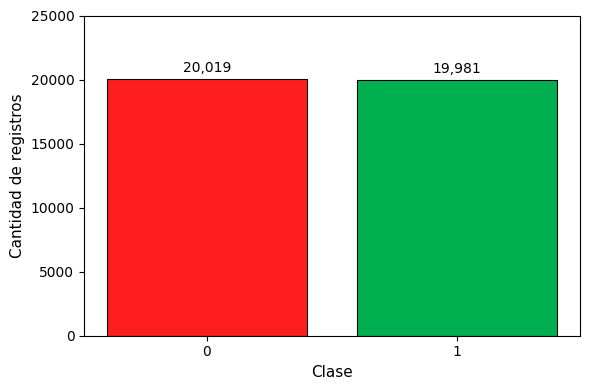

Registros únicos: 39,723
Registros duplicados: 277
Registros nulos: 0

Promedio de palabras por registro: 231.34

Palabras más frecuentes:
br: 22748
movie: 16740
film: 14685
one: 10037
like: 7634
good: 5693
even: 5015
would: 4822
time: 4687
really: 4564
see: 4468
story: 4319
much: 3806
well: 3706
get: 3694
also: 3611
bad: 3602
great: 3566
people: 3530
first: 3394
dont: 3262
films: 3133
could: 3092
movies: 3092
made: 3018
make: 2961
characters: 2937
way: 2929
think: 2792
watch: 2718
many: 2690
character: 2647
seen: 2645
never: 2582
plot: 2582
love: 2564
acting: 2531
best: 2524
show: 2508
two: 2501
little: 2443
know: 2441
ever: 2361
life: 2348
better: 2213
still: 2137
say: 2120
end: 2093
scenes: 1995
something: 1958
scene: 1957
man: 1945
go: 1905
im: 1900
thing: 1829
real: 1827
didnt: 1819
watching: 1802
actors: 1785
doesnt: 1782
back: 1764
actually: 1751
years: 1725
another: 1701
though: 1686
makes: 1668
nothing: 1646
find: 1632
look: 1627
going: 1625
work: 1615
part: 1611
funny: 1610
l

<Figure size 640x480 with 0 Axes>

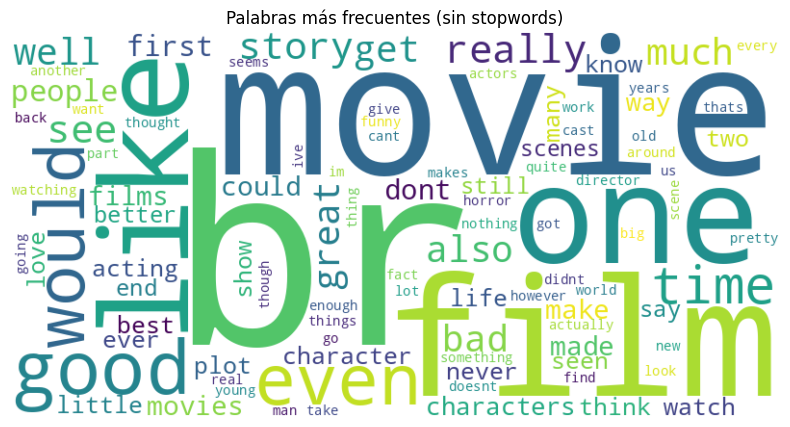

<Figure size 640x480 with 0 Axes>

In [8]:
#--------------------------------------------
# ANÁLISIS EXPLORATORIO
#--------------------------------------------
cantidad_registros = len(df)
print(f"Cantidad total de registros: {cantidad_registros:,}")

# Gráfico de barras
conteo_clases = df["label"].value_counts()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(conteo_clases.index.astype(str),
       conteo_clases.values,
       color=['#FF1E1E', '#00B050'],  # rojo fuerte y verde elegante
       edgecolor='black', linewidth=0.8)
for i, val in enumerate(conteo_clases.values):
    ax.text(i, val + 300, f'{val:,}', ha='center', va='bottom', fontsize=10)
ax.set_xlabel('Clase', fontsize=11)
ax.set_ylabel('Cantidad de registros', fontsize=11)
ax.set_facecolor('white')
ax.grid(False)
ax.set_ylim(0, 25000)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.8)
plt.tight_layout()
plt.show()
plt.savefig(f"{base_dir}/barras_clase.svg", format='svg', dpi=300, bbox_inches='tight')

# Limpieza de texto (sin stopwords)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    words = [w for w in text.split() if w not in stop_words]
    return words

# Procesar solo una muestra si el dataset es grande
sample_df = df.sample(n=min(10000, len(df)), random_state=42)
all_words = sample_df["text"].dropna().apply(clean_text).sum()

#Registro unicos y duplicados
registros_unicos = df["text"].nunique()
duplicados = df.duplicated(subset=["text"]).sum()
print(f"Registros únicos: {registros_unicos:,}")
print(f"Registros duplicados: {duplicados:,}")

#Registros nulos
print(f"Registros nulos: {df.isnull().sum().sum():,}")

# Promedio de palabras por registro
df['word_count'] = df["text"].apply(lambda x: len(str(x).split()))
promedio_palabras = df['word_count'].mean()
print(f"\nPromedio de palabras por registro: {promedio_palabras:.2f}")

# Palabras más frecuentes
sample_df = df.sample(n=min(10000, len(df)), random_state=random_state)
all_words = sample_df["text"].dropna().apply(clean_text).sum()
word_freq = Counter(all_words).most_common(100)
print("\nPalabras más frecuentes:")
for w, f in word_freq:
    print(f"{w}: {f}")

#Nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes (sin stopwords)')
plt.show()
plt.savefig(f"{base_dir}/nube_palabras.svg", format='svg', dpi=300, bbox_inches='tight')


# División de Datos: Entrenamiento, Validación y Prueba (80 / 10 / 10)

Con el fin de evaluar el rendimiento del modelo de forma objetiva, el conjunto de datos se divide en tres subconjuntos:

- **Entrenamiento (80 %)**: utilizado para ajustar los parámetros del modelo.  
- **Validación (10 %)**: empleado para ajustar hiperparámetros y detectar sobreajuste.  
- **Prueba (10 %)**: reservado para medir el desempeño final del modelo con datos no vistos.

**Pasos realizados:**

1. Eliminación de registros duplicados para evitar sesgos.  
2. Separación de variables predictoras (`X`: texto) y objetivo (`y`: etiqueta).  
3. Uso de `train_test_split` de *scikit-learn* con una semilla (`random_state`) fija para garantizar la reproducibilidad.  
4. Cálculo de los **percentiles 90 y 95** de la longitud de las reseñas, lo cual ayuda a definir el tamaño máximo de secuencia (`max_len`) para el posterior proceso de *tokenización*.




In [9]:
#--------------------------------------------
# DIVISIÓN TRAIN-VALIDATION-TEST (80/10/10)
#--------------------------------------------

#Elimina los datos duplicados
df = df.drop_duplicates()

#Separación train/val/test
X = df["text"]
y = df["label"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)


lengths = [len(x.split()) for x in X_train]
p90 = np.percentile(lengths, 90)
p95 = np.percentile(lengths, 95)
print(f"Percentil 90: {p90}, Percentil 95: {p95}")

Percentil 90: 452.0, Percentil 95: 591.1499999999978


# Pipeline de Preprocesamiento de Texto

En esta sección se define una clase llamada **`TextPipeline`**, encargada de automatizar el flujo de preparación del texto antes de ser ingresado a la red neuronal.  
Este pipeline centraliza todas las etapas del preprocesamiento, asegurando consistencia y reproducibilidad en el tratamiento de los datos.

**Funciones principales:**

1. **Limpieza básica (`_clean`)**  
   - Convierte el texto a minúsculas.  
   - Elimina etiquetas HTML, signos de puntuación y caracteres no alfabéticos.  
   - Normaliza espacios múltiples.

2. **Tokenización (`fit_tokenizer`)**  
   - Crea un *tokenizer* de Keras limitado a un número máximo de palabras (`num_words`).  
   - Genera un diccionario de palabras → índices.

3. **Conversión a secuencias (`transform` y `fit_transform`)**  
   - Transforma el texto limpio en secuencias numéricas.  
   - Aplica *padding* o *truncado* para uniformar la longitud a `max_len`.

4. **Gestión del tokenizador (`save_tokenizer` / `load_tokenizer`)**  
   - Permite guardar y cargar el tokenizador en formato JSON para su reutilización.  


In [10]:
#--------------------------------------------
# PIPELINE DE PREPROCESAMIENTO
#--------------------------------------------
class TextPipeline:
    """
    Pipeline de preprocesamiento de texto:
    - convierte a minúsculas
    - elimina HTML y signos de puntuación
    - tokeniza (Keras Tokenizer)
    - convierte a secuencias
    - aplica padding a longitud fija
    """

    def __init__(
        self,
        max_len: int,
        num_words: Optional[int],   # límite de vocabulario
        oov_token: str = "<UNK>",           # token para palabras fuera de vocabulario
        padding: str = "post",              # 'pre' o 'post'
        truncating: str = "post"            # 'pre' o 'post'
    ):
        self.max_len = max_len
        self.num_words = num_words
        self.oov_token = oov_token
        self.padding = padding
        self.truncating = truncating
        self.tokenizer: Optional[Tokenizer] = None

    # --------- limpieza básica ---------
    @staticmethod
    def _clean(text: str) -> str:
        """Limpia el texto eliminando HTML, signos y espacios múltiples."""
        if text is None:
            return ""
        # quitar etiquetas HTML
        text = re.sub(r"<.*?>", " ", text)
        # convertir a minúsculas
        text = text.lower()
        # eliminar todo lo que no sean letras o espacios
        text = re.sub(r"[^a-z\s]", " ", text)
        # colapsar múltiples espacios
        text = re.sub(r"\s+", " ", text).strip()
        return text

    # --------- ajuste del tokenizador ---------
    def fit_tokenizer(self, texts: List[str]) -> None:
        """Ajusta el tokenizador a una lista de textos."""
        cleaned = [self._clean(t) for t in texts]
        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token=self.oov_token)
        self.tokenizer.fit_on_texts(cleaned)

    # --------- transformar textos ---------
    def transform(self, texts: List[str]) -> Tuple[list, list]:
        """
        Transforma los textos a secuencias y aplica padding.
        Devuelve:
        - sequences: listas de índices (longitud variable)
        - padded: secuencias con padding a max_len
        """
        if self.tokenizer is None:
            raise ValueError("El tokenizador no ha sido ajustado. Llama primero a fit_tokenizer().")

        # limpiar los textos antes de transformar
        cleaned = [self._clean(t) for t in texts]
        # convertir textos a secuencias de índices
        sequences = self.tokenizer.texts_to_sequences(cleaned)
        # aplicar padding a las secuencias
        padded = pad_sequences(
            sequences,
            maxlen=self.max_len,
            padding=self.padding,
            truncating=self.truncating
        )
        return sequences, padded

    def fit_transform(self, texts: List[str]) -> np.ndarray:
        """Ajusta el tokenizador y devuelve las secuencias con padding."""
        self.fit_tokenizer(texts)
        _, padded = self.transform(texts)
        return padded

    # --------- helpers ---------
    def vocab_size(self) -> int:
        """Devuelve el tamaño del vocabulario (+1 por el índice reservado)."""
        if self.tokenizer is None:
            return 0
        return (self.num_words or len(self.tokenizer.word_index)) + 1

    def word_index(self):
        """Devuelve el diccionario palabra → índice."""
        if self.tokenizer is None:
            return {}
        return self.tokenizer.word_index

    def save_tokenizer(self, path: str) -> None:
        """Guarda el tokenizador entrenado en formato JSON."""
        if self.tokenizer is None:
            raise ValueError("El tokenizador no ha sido ajustado aún.")
        with open(path, "w", encoding="utf-8") as f:
            f.write(self.tokenizer.to_json())

    def load_tokenizer(self, path: str) -> None:
        """Carga un tokenizador previamente guardado desde un archivo JSON."""
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        self.tokenizer = tokenizer_from_json(data)

# Ajuste y Transformación del Tokenizador

En esta etapa se utiliza la clase `TextPipeline` para **convertir el texto en secuencias numéricas** listas para ser procesadas por la red neuronal.

**Pasos realizados:**

1. **Instanciación del pipeline**  
   Se crea un objeto `TextPipeline` definiendo:
   - `max_len = 450`: longitud máxima de secuencia (basada en los percentiles 90–95 del análisis previo).  
   - `num_words = 30,000`: tamaño máximo del vocabulario, priorizando las palabras más frecuentes.

2. **Ajuste del tokenizador (`fit_tokenizer`)**  
   El tokenizador se entrena **únicamente con los textos de entrenamiento** (`X_train`), para evitar *data leakage* desde los conjuntos de validación y prueba.

3. **Transformación de textos (`transform`)**  
   Convierte los textos de cada subconjunto (*train*, *val* y *test*) en secuencias de índices numéricos.  
   Posteriormente aplica **padding** para igualar la longitud de las entradas a `max_len`.


In [11]:
#--------------------------------------------
# AJUSTE Y TRANSFORMACIÓN DEL TOKENIZADOR
#--------------------------------------------
# Crear una instancia del pipeline
pipeline = TextPipeline(max_len=450, num_words=30000)

# Ajustar el tokenizador solo con los textos de entrenamiento
pipeline.fit_tokenizer(X_train)

# Transformar los conjuntos de texto en secuencias y aplicar padding
_, X_train_pad = pipeline.transform(X_train)
_, X_val_pad = pipeline.transform(X_val)
_, X_test_pad = pipeline.transform(X_test)

# Creación del Embedding Preentrenado (GloVe 300D)

En esta sección se construye la **matriz de embeddings** que servirá como entrada a la red neuronal recurrente.  
Se utiliza el modelo **preentrenado `glove-wiki-gigaword-300`**, el cual contiene representaciones vectoriales de palabras entrenadas sobre **6 mil millones de tokens** del corpus de Wikipedia y Gigaword.

**Pasos principales:**

1. **Carga del modelo preentrenado**  
   A través de `gensim.downloader.api`, se descarga el modelo `glove-wiki-gigaword-300`, con una dimensión de 300 por palabra.

2. **Construcción de la matriz de embeddings (`embedding_matrix`)**  
   - Se crea una matriz de ceros con tamaño `(vocab_size, embedding_dim)`.  
   - Para cada palabra del vocabulario del tokenizador (`word_index`), se verifica si existe en el modelo GloVe.  
   - Si la palabra está presente, se copia su vector correspondiente en la posición asignada.

3. **Cálculo de cobertura**  
   Se muestra el porcentaje de palabras del vocabulario que tienen representación en el modelo preentrenado.


In [12]:
#--------------------------------------------
# CREACIÓN DEL EMBEDDING
#--------------------------------------------
# Carga el modelo glove-wiki-gigaword-300
w2v_model = api.load("glove-wiki-gigaword-300")

print("Modelo cargado correctamente.")
print("Dimensión del embedding:", w2v_model.vector_size)

vocab_size = pipeline.vocab_size()
word_index = pipeline.word_index()

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

found = np.count_nonzero(np.any(embedding_matrix, axis=1))
coverage = found / vocab_size * 100
print(f"Palabras cubiertas por Word2Vec: {found}/{vocab_size} ({coverage:.2f}%)")


[==================================================] 100.0% 376.1/376.1MB downloaded
Modelo cargado correctamente.
Dimensión del embedding: 300
Palabras cubiertas por Word2Vec: 29496/30001 (98.32%)


# Construcción del Modelo RNN Bidireccional (GRU)

En esta sección se define la arquitectura del modelo de **análisis de sentimientos** basada en una **Red Neuronal Recurrente (RNN)** con unidades **GRU (Gated Recurrent Units)**.  
El objetivo es capturar dependencias contextuales en secuencias de texto, aprovechando embeddings preentrenados.

**Estructura del modelo:**

1. **Capa Embedding**  
   - Inicializada con la matriz preentrenada `embedding_matrix` (GloVe 300D).  
   - Parámetros: `input_dim = vocab_size`, `output_dim = embedding_dim`, `input_length = max_len`.  
   - `trainable = True`: permite ajustar los vectores durante el entrenamiento para adaptar el modelo al dominio específico.

2. **SpatialDropout1D(0.35)**  
   - Aplica un *dropout espacial* sobre los embeddings, reduciendo la co-adaptación de las neuronas y mitigando el sobreajuste.

3. **Bidirectional(GRU(64, dropout=0.4, recurrent_dropout=0.2))**  
   - Capa recurrente con 64 unidades GRU en ambas direcciones (hacia adelante y hacia atrás).  
   - El *dropout* y *recurrent_dropout* actúan como regularizadores para mejorar la generalización.

4. **Dense(1, activation='sigmoid')**  
   - Capa de salida binaria con activación sigmoide para clasificar entre sentimiento **positivo (1)** o **negativo (0)**.  
   - Se añade una penalización `l2(1e-3)` para regularizar los pesos.

5. **Compilación del modelo**  
   - Función de pérdida: `binary_crossentropy`.  
   - Optimizador: `Adam` con *learning rate* de `2e-4`.  
   - Métrica: `accuracy`.

In [13]:
#--------------------------------------------
# CREACIÓN DE RNN
#--------------------------------------------
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=pipeline.max_len,
        trainable=True  # los embeddings son entrenables
    ),
    SpatialDropout1D(0.35),
    Bidirectional(GRU(64, dropout=0.4,recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-3), dtype='float32')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,300 (34.33 MB)

 Trainable params: 9,000,300 (34.33 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks del entrenamiento

Este bloque configura los **callbacks** que optimizan el entrenamiento del modelo.  
Incluye:
- `ReduceLROnPlateau`: ajusta el *learning rate* cuando la pérdida de validación se estanca.  
- `EarlyStopping`: detiene el entrenamiento si no hay mejora.  
- `ModelCheckpoint`: guarda el mejor modelo.  
- `LrLogger`: registra la tasa de aprendizaje por época.  

En conjunto, ayudan a prevenir el sobreajuste y mejorar la estabilidad del entrenamiento.

In [14]:
# ==========================================================
# CALLBACKS
# ==========================================================
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True, verbose=1)


# ==========================================================
# CALLBACK ADICIONAL: REGISTRO DEL LEARNING RATE
# ==========================================================
class LrLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        opt = self.model.optimizer

        # Si está envuelto (mixed precision)
        if hasattr(opt, 'optimizer'):
            opt = opt.optimizer

        # Buscar la propiedad del learning rate
        lr_attr = getattr(opt, 'lr', None) or getattr(opt, 'learning_rate', None)
        if lr_attr is None:
            print(f"Epoch {epoch+1}: ⚠️ No se pudo obtener el learning rate.")
            return

        # Obtener valor numérico (Variable, tensor o float)
        try:
            lr_value = float(tf.keras.backend.get_value(lr_attr))
        except:
            try:
                lr_value = float(lr_attr.numpy())
            except:
                lr_value = float(lr_attr)

        # Agregarlo al diccionario logs (esto lo guarda en history.history)
        logs['lr'] = lr_value
        print(f"Epoch {epoch+1}: Learning Rate = {lr_value:.6f}")



# Añadir a la lista de callbacks
callbacks = [reduce_lr, early_stop, checkpoint, LrLogger()]
print("Callbacks configurados con registro de learning rate.")

Callbacks configurados con registro de learning rate.


# Entrenamiento del Modelo RNN

En esta etapa se entrena la red neuronal recurrente (GRU) utilizando los conjuntos de entrenamiento y validación previamente preparados.  
Durante el proceso, los *callbacks* configurados supervisan la evolución de la pérdida y la tasa de aprendizaje.

**Detalles del entrenamiento:**

- **Datos**:  
  - Entrenamiento: `X_train_pad`, `y_train`  
  - Validación: `X_val_pad`, `y_val`  

- **Hiperparámetros**:  
  - Épocas (`epochs`): `25`  
  - Tamaño de lote (`batch_size`): `128`  
  - Optimizador: *Adam* con *learning rate* adaptativo (controlado por `ReduceLROnPlateau`).  
  - Pérdida: `binary_crossentropy`  
  - Métrica: `accuracy`

- **Callbacks activos**:  
  - Ajuste dinámico del *learning rate* (`ReduceLROnPlateau`)  
  - Detención temprana (`EarlyStopping`)  
  - Guardado del mejor modelo (`ModelCheckpoint`)  
  - Registro del *learning rate* (`LrLogger`)

El objeto `history` almacenará la evolución de las métricas de entrenamiento y validación, lo que permitirá analizar gráficamente el desempeño del modelo y verificar si existe sobreajuste.


In [15]:
#--------------------------------------------
# ENTRENAMIENTO RNN
#--------------------------------------------
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5201 - loss: 0.7001
Epoch 1: val_loss improved from inf to 0.68007, saving model to best_gru_model.keras
Epoch 1: Learning Rate = 0.000200
125/125 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.5202 - loss: 0.7000 - val_accuracy: 0.5826 - val_loss: 0.6801 - learning_rate: 2.0000e-04 - lr: 2.0000e-04
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5704 - loss: 0.6814
Epoch 2: val_loss improved from 0.68007 to 0.66243, saving model to best_gru_model.keras
Epoch 2: Learning Rate = 0.000200
125/125 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.5704 - loss: 0.6814 - val_accuracy: 0.6161 - val_loss: 0.6624 - learning_rate: 2.0000e-04 - lr: 2.0000e-04
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5971 - loss: 0.6672
Epoch 3: val_loss improved from 0.66243 to 0.62962, saving model to best_gru_model.keras
Epoch 3: Learning Rate = 0.000200
125/125 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 

# Gráficas de entrenamiento y tasa de aprendizaje

Este bloque genera tres gráficos que muestran la evolución del **accuracy**, la **pérdida (loss)** y el **learning rate** a lo largo de las épocas.  
Permite visualizar el comportamiento del modelo en entrenamiento y validación, identificar posibles signos de sobreajuste y analizar cómo varía la tasa de aprendizaje durante el proceso.


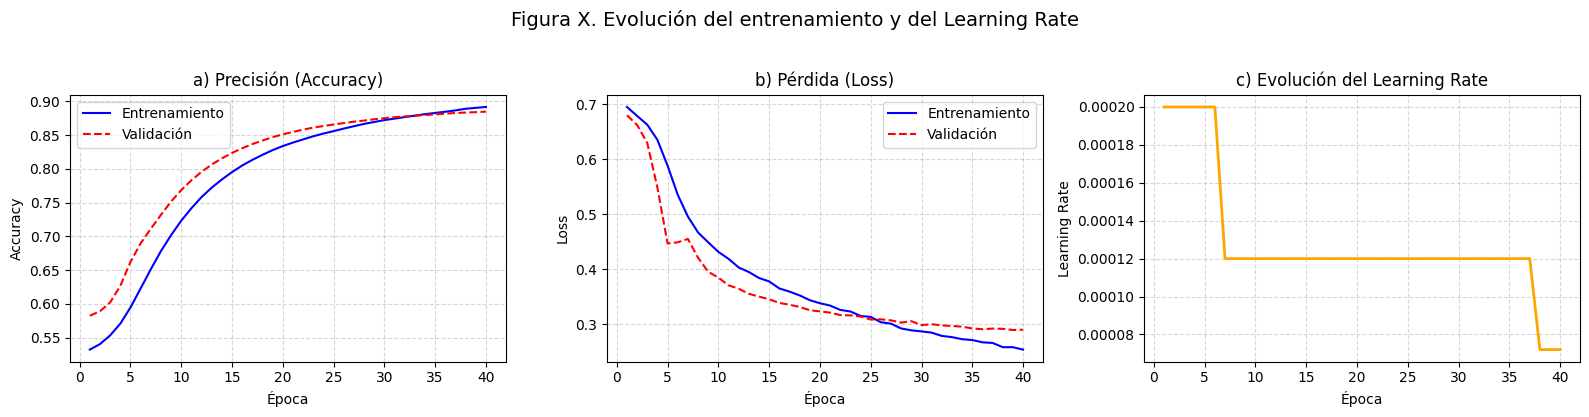

In [16]:
# ==========================================================
# GRÁFICAS DE ENTRENAMIENTO, VALIDACIÓN Y LEARNING RATE
# ==========================================================
def smooth(values, factor=0.8):
    smoothed = []
    last = values[0]
    for v in values:
        smoothed.append(last * factor + (1 - factor) * v)
        last = smoothed[-1]
    return smoothed

acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
lr = history.history.get('lr', [])

epochs_range = range(1, len(acc) + 1)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Figura X. Evolución del entrenamiento y del Learning Rate", fontsize=14, y=1.03)

# ----------------------------------------------------------
# Accuracy
# ----------------------------------------------------------
axes[0].plot(epochs_range, smooth(acc), 'b-', label='Entrenamiento')
axes[0].plot(epochs_range, smooth(val_acc), 'r--', label='Validación')
axes[0].set_title('a) Precisión (Accuracy)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# ----------------------------------------------------------
# Loss
# ----------------------------------------------------------
axes[1].plot(epochs_range, loss, 'b-', label='Entrenamiento')
axes[1].plot(epochs_range, val_loss, 'r--', label='Validación')
axes[1].set_title('b) Pérdida (Loss)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# ----------------------------------------------------------
# Learning Rate
# ----------------------------------------------------------
if lr and len(lr) == len(acc):
    axes[2].plot(epochs_range, lr, color='orange', linewidth=2)
    axes[2].set_title('c) Evolución del Learning Rate')
    axes[2].set_xlabel('Época')
    axes[2].set_ylabel('Learning Rate')
    axes[2].grid(True, linestyle='--', alpha=0.5)
else:
    axes[2].text(0.5, 0.5, "LR no registrado", ha='center', va='center', fontsize=12)

plt.tight_layout()
#Guarda la figura
svg_path =  "mri_training_validation_lr.svg"
plt.savefig(svg_path, format="svg", bbox_inches="tight")
plt.show()

# Evaluación del modelo

Este bloque evalúa el rendimiento del modelo en el conjunto de **prueba**, calculando métricas como **accuracy**, **precision**, **recall** y **F1-score**.  
También genera la **matriz de confusión** y un **reporte de clasificación** para analizar los aciertos y errores del modelo, visualizando los resultados con un mapa de calor.

Test Accuracy: 0.8955
Test Loss: 0.2578
Matriz de confusión:
 [[1800  211]
 [ 204 1758]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8982    0.8951    0.8966      2011
           1     0.8928    0.8960    0.8944      1962

    accuracy                         0.8955      3973
   macro avg     0.8955    0.8956    0.8955      3973
weighted avg     0.8956    0.8955    0.8955      3973

Accuracy: 0.8955
Precision: 0.8928
Recall: 0.8960
F1-Score: 0.8944


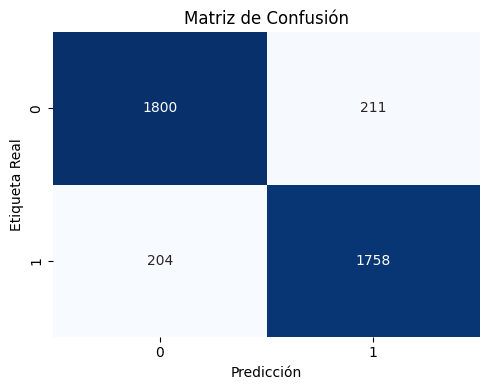

In [17]:
# ==========================================================
# EVALUACIÓN
# ==========================================================

# Evaluación en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predicciones (probabilidades)
y_pred_probs = model.predict(X_test_pad, verbose=0)

# Umbral de decisión (por defecto 0.5, pero se puede ajustar si lo analizas luego)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

# Reporte detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# Métricas globales
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

#Matriz de confusión plot

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.tight_layout()
plt.show()

# Muestra cualitativa de predicciones

Este bloque selecciona **10 ejemplos aleatorios** del conjunto de prueba y muestra el texto original, la **etiqueta real**, la **predicción del modelo** y la **probabilidad asignada** a la clase positiva.  
Sirve para realizar una evaluación cualitativa del desempeño del modelo y observar cómo interpreta diferentes reseñas.


In [18]:
# ===============================================================
# MUESTRA ALEATORIA DE 10 EJEMPLOS PARA RESULTADOS CUALITATIVOS
# ===============================================================

# Seleccionar 10 índices aleatorios
idx = np.random.choice(len(y_test), size=10, replace=False)

# Crear DataFrame con ejemplos
sample_df = pd.DataFrame({
    'Texto': [X_test.iloc[i][:120] + "..." if isinstance(X_test.iloc[i], str) else str(X_test.iloc[i]) for i in idx],
    'Etiqueta Real': y_test.iloc[idx].values,
    'Predicción Modelo': y_pred[idx].flatten(),
    'Probabilidad (clase 1)': np.round(y_pred_probs[idx].flatten(), 4)
})

# Mostrar tabla ordenada por probabilidad
display(sample_df.sort_values(by='Probabilidad (clase 1)', ascending=False).reset_index(drop=True))

,Texto,Etiqueta Real,Predicción Modelo,Probabilidad (clase 1)
0,A teen-aged girl gets the horse of her dreams ...,1,1,0.9032
1,A humorous voyage into the normally somber fun...,1,1,0.8650
2,I admit that the majority of this film was uni...,0,1,0.8139
3,Care Bears Movie 2: A New Generation isn't at ...,1,1,0.7442
4,First things first: I'm not a conservative. An...,0,0,0.0966
5,Well let's be fair. Following up a cult classi...,0,0,0.0223
6,I really wish Hollywood would come up with som...,0,0,0.0121
7,How sad to see the beautiful and talented Tina...,0,0,0.0089
8,One of the worst Arnold movies I've seen. Spec...,0,0,0.0043
9,"I have seen tons of trash, in every language, ...",0,0,0.0036
